# Duds During Darden's Duration:
## Anomaly Detection in Access Logs
#### Kwame V. Taylor

Project Description Here.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=15)

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# importing GeoIP database for IP geolocation
import geoip2.database
reader = geoip2.database.Reader('GeoLite2City/GeoLite2-City.mmdb')

# import system to check errors
import sys

### Acquire

In [2]:
colnames = ['date', 'timestamp', 'request_method', 'user_id', 'cohort_id', 'ip']

df = pd.read_csv('anonymized-curriculum-access.txt', header=None, index_col=False,
                 names=colnames, delim_whitespace=True, na_values='"-"')
#                 usecols=[0, 1, 2, 5])
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61


### Prepare

In [3]:
# merge date and timestamp
df["ds"] = df["date"] +" "+ df["timestamp"]
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip,ds
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [4]:
# drop date and timestamp
df = df.drop(columns=['date', 'timestamp'])
df.head()

,request_method,user_id,cohort_id,ip,ds
0,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [5]:
# convert date column to datetime type
df.ds = pd.to_datetime(df.ds)
df.dtypes

request_method            object
user_id                    int64
cohort_id                 object
ip                        object
ds                datetime64[ns]
dtype: object

In [6]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('ds').sort_index()
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [7]:
df.shape

(719459, 4)

In [8]:
df.request_method.value_counts()

/                                                40122
search/search_index.json                         15393
javascript-i                                     14551
toc                                              14018
java-iii                                         10835
                                                 ...  
users/1/edit                                         1
10-nlp/topic-modeling                                1
ltc-ml/slides/1                                      1
content/examples/javascript/conditionals.html        1
javascript-i/primitive-types                         1
Name: request_method, Length: 2154, dtype: int64

In [9]:
df.ip.value_counts()

97.105.19.58       268648
97.105.19.61        60530
192.171.117.210      8896
71.150.217.33        4919
12.106.208.194       4262
                    ...  
99.203.155.226          1
173.123.135.208         1
107.77.80.32            1
208.54.83.234           1
99.203.27.48            1
Name: ip, Length: 4064, dtype: int64

In [10]:
df.cohort_id.nunique()

386

Some IP addresses accidentally got put in the ```cohort_id``` column, so I'm going to drop those rows.

In [11]:
df = df.drop(df[df.cohort_id.str.len() > 4].index)
df

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175
2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175


In [12]:
#sample code from ryan, for reference
#mask = (df.column.str.contains(“A”) | df.column.str.contains(“B”))
#df[mask]

**Drop nulls**

In [13]:
df.isna().sum()

request_method      0
user_id             0
cohort_id         420
ip                  0
dtype: int64

In [14]:
df = df.dropna()

I noticed there are some requests that are just ```/```. In the interest of time, I am choosing to just drop those rows for now, as I didn't see any pattern to the distrubution of them and assume it's something to do with the syntax reading read in wrong or there being missing data in the raw data file I imported.

**Drop bad request_methods**

In [115]:
# there are over 10,000 of these '/' requests
df.groupby(['request_method']).filter(lambda x : len(x)>10000).head(3)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,97105,1961
2018-01-26 10:00:37,/,6,22,97.105.19.61,97105,1961
2018-01-26 10:00:39,javascript-i,6,22,97.105.19.61,97105,1961


In [117]:
df = df.drop(df[df.request_method.str.len() < 2].index)
df.head()

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97105,1961


**Split IP address into network and host**
 * **Reference**: https://docs.oracle.com/cd/E19504-01/802-5753/planning3-18471/index.html

In [15]:
df[['network1','network2', 'host1', 'host2']] = df.ip.str.split(".",expand=True)
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2
ds,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61


In [16]:
df['network'] = df['network1'] + df['network2']
df['host'] = df['host1'] + df['host2']
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2,network,host
ds,,,,,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61,97105,1961


**I notice that there is at least one instance of a different user_id under the same exact IP address. Might be a typo, or just something I don't understand about IP addresses.**

In [17]:
df = df.drop(columns=['network1', 'network2', 'host1', 'host2'])
df.head()

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961


In [18]:
df.network.nunique()

715

In [19]:
df.host.nunique()

3909

### Explore & Feature Engineering

In [20]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'event_count']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

,ip
event_count,
1,586
2,409
3,377
4,285
5,198
...,...
4261,1
4913,1
8894,1


In [21]:
# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

4.198177987557075

**Make darden_df for just dates from Darden cohort**

In [22]:
df.tail(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,172125,226175
2020-11-02 16:48:47,javascript-i/bom-and-dom/bom,763,62,107.192.148.199,107192,148199


In [23]:
darden_df = df.loc['2020-07-13':'2020-11-02']
darden_df.head(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224


In [24]:
darden_df.shape

(105988, 6)

### Geolocation Exploration

**Add City Feature**

In [25]:
def add_city(ip):
    try:
        response = reader.city(ip)
        city_name = response.city.name
        return city_name
    except:
        return np.nan

In [26]:
darden_df['city'] = darden_df.apply(lambda darden_df: add_city(darden_df['ip']),axis=1)

In [27]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne


In [30]:
darden_df.city.nunique()

109

In [29]:
darden_df.city.value_counts()

San Antonio           72917
Dallas                 5817
Boerne                 3678
New Braunfels          2064
Austin                 1566
                      ...  
Hilton Head Island        1
Pflugerville              1
Floresville               1
Whittier                  1
Palestine                 1
Name: city, Length: 108, dtype: int64

In [32]:
darden_df.shape

(105988, 7)

In [52]:
city_plot_df = darden_df.groupby('city').filter(lambda x : len(x)>900)
city_plot_df.city.nunique()

12

In [73]:
# default viz size settings
plt.rc('figure', figsize=(14, 9))
plt.rc('font', size=15)

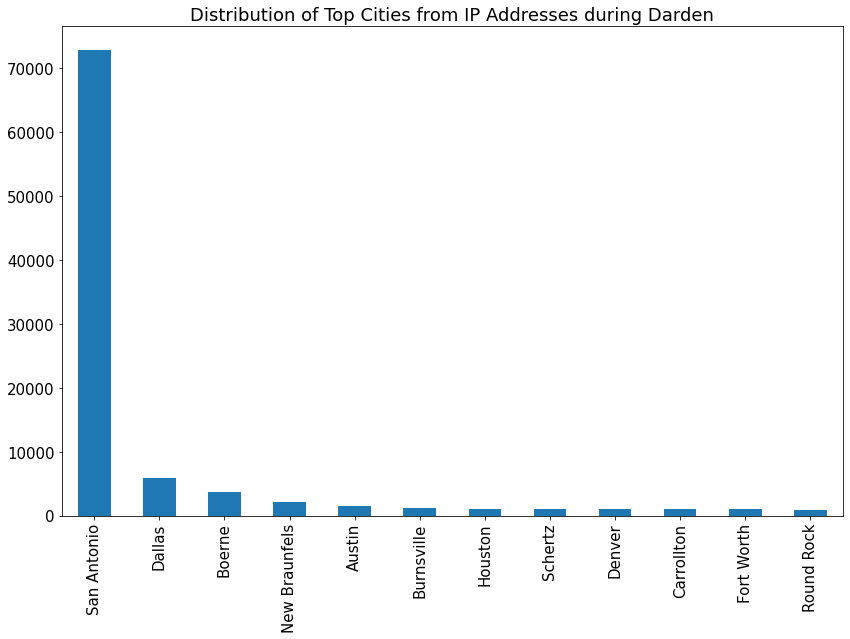

In [78]:
city_plot_df['city'].value_counts().plot(kind='bar')
plt.title('Distribution of Top Cities from IP Addresses during Darden')
plt.show()

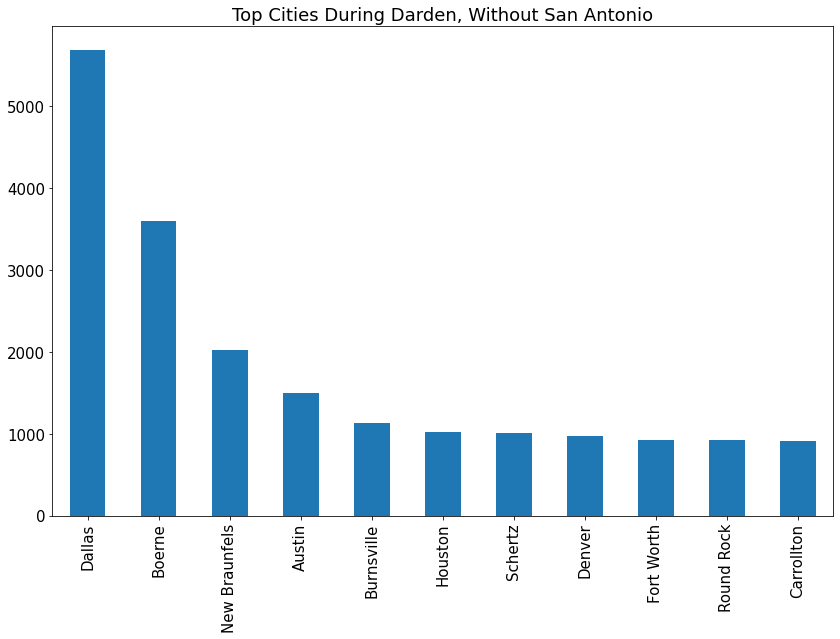

In [79]:
city_plot_df['city'].drop(city_plot_df[city_plot_df.city == 'San Antonio'].index).value_counts().plot(kind='bar')
plt.title('Top Cities During Darden, Without San Antonio')
plt.show()

In [51]:
city_plot_anomalies = darden_df.groupby('city').filter(lambda x : len(x)<3)
city_plot_anomalies.city.nunique()

11

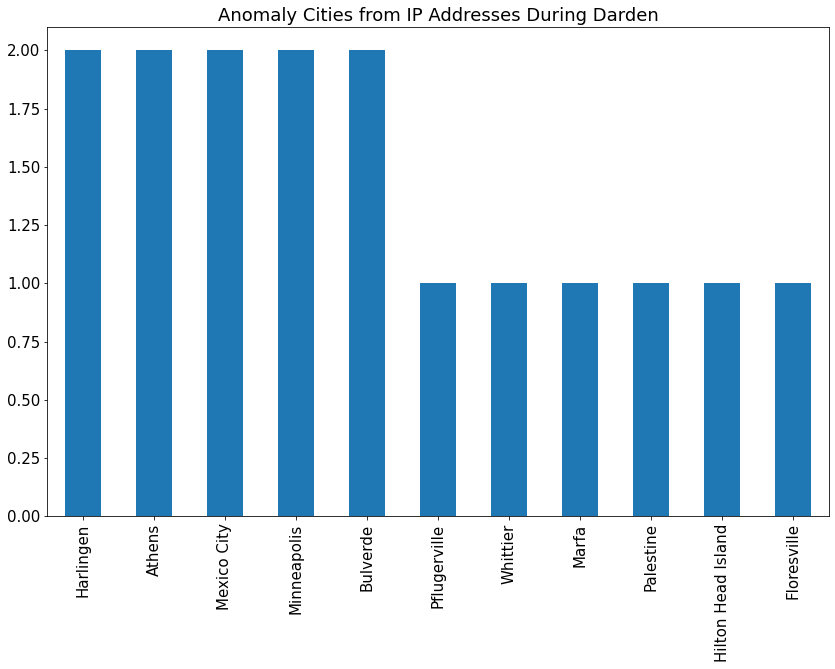

In [81]:
city_plot_anomalies['city'].value_counts().plot(kind='bar')
plt.title('Anomaly Cities from IP Addresses During Darden')
plt.show()

**Takeaways:** Athens, Mexico City, and Palestine (it seems GeoLite couldn't acquire the city in some places and gave me the country instead) are all in other countries, so I'm going to see if I can zoom in on geolocations from outside the USA.

**Create Country feature**

Note: Still working with just the Darden duration data so that my geolocation code isn't too computationally expensive.

In [82]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne


**Plot distributions of request_methods by user**

In [ ]:
darden_df.groupby('request_method')

In [119]:
darden_df.groupby(['request_method']).filter(lambda x : len(x)>7100)

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 02:23:29,/,566,53,67.11.136.146,6711,136146,San Antonio
2020-07-13 07:41:57,/,665,58,71.136.251.103,71136,251103,San Antonio
2020-07-13 08:26:34,/,676,58,136.50.56.65,13650,5665,San Antonio
2020-07-13 08:28:59,/,640,57,67.11.138.20,6711,13820,San Antonio
2020-07-13 08:36:58,/,675,58,70.240.251.44,70240,25144,San Antonio
...,...,...,...,...,...,...,...
2020-11-02 15:38:05,/,419,32,72.181.98.75,72181,9875,San Antonio
2020-11-02 15:38:05,/,694,59,172.58.107.212,17258,107212,Dallas
2020-11-02 15:57:22,/,616,55,70.114.9.241,70114,9241,New Braunfels


### Hypothesis 1:
    
    